In [1]:
import numpy as np
import seaborn as sns
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime as dt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [2]:
MAX_EPOCHS = 30

def buildDataframe(countyString):
    #load data, renames columns, converts timestamps to datetime, sets datetime as index, & concatenates datasets
    dfMax = pd.read_csv(countyString+"-tmax-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMax['Date'] = pd.to_datetime(dfMax['Date'], yearfirst = True, format = "%Y%m")
    dfMax = dfMax.rename(columns={dfMax.columns[1]:'MaxTempF'})
    dfMax = dfMax.rename(columns={dfMax.columns[2]:'MaxAnomalyF'})
    dfMax = dfMax.set_index(dfMax['Date'])
    del dfMax['Date']

    dfMin = pd.read_csv(countyString+"-tmin-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMin['Date'] = pd.to_datetime(dfMin['Date'], yearfirst = True, format = "%Y%m")
    dfMin = dfMin.rename(columns={dfMin.columns[1]:'MinTempF'})
    dfMin = dfMin.rename(columns={dfMin.columns[2]:'MinAnomalyF'})
    dfMin = dfMin.set_index(dfMin['Date'])
    del dfMin['Date']

    dfAvg = pd.read_csv(countyString+"-tavg-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfAvg['Date'] = pd.to_datetime(dfAvg['Date'], yearfirst = True, format = "%Y%m")
    dfAvg = dfAvg.rename(columns={dfAvg.columns[1]:'AvgTempF'})
    dfAvg = dfAvg.rename(columns={dfAvg.columns[2]:'AvgAnomalyF'})
    dfAvg = dfAvg.set_index(dfAvg['Date'])
    del dfAvg['Date']

    dfPrecip = pd.read_csv(countyString+"-pcp-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfPrecip['Date'] = pd.to_datetime(dfPrecip['Date'], yearfirst = True, format = "%Y%m")
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[1]:'PrecipitationIn'})
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[2]:'PrecipAnomalyIn'})
    dfPrecip = dfPrecip.set_index(dfPrecip['Date'])
    del dfPrecip['Date']

    df = pd.concat([dfMax, dfMin, dfPrecip, dfAvg], axis=1)
    return df

def split_normalizeData(df):
    #splits data into training (70%), validation (20%), & test (10%), then normalizes all
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    num_features = df.shape[1]
    #normalizes using training data only so models don't have access to validation & test data
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return train_df, val_df, test_df

def compile_and_fit(model, window):
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val)
    return history

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
     # Slicing doesn't preserve static shape information, so set the shapes
     # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def plot(self, model=None, plot_col='AvgTempF', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [mos]')
    
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None,
      sequence_length=self.total_window_size, sequence_stride=1, shuffle=True, batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [3]:
#loads data & splits datasets for Wayne County (Detroit, MI), Cook County (Chicago, IL), & Nueces County
dfWayne = buildDataframe('MI-163')
dfCook = buildDataframe('IL-031')
dfNueces = buildDataframe('TX-355')
train_Wayne, val_Wayne, test_Wayne = split_normalizeData(dfWayne)
train_Cook, val_Cook, test_Cook = split_normalizeData(dfCook)
train_Nueces, val_Nueces, test_Nueces = split_normalizeData(dfNueces)
column_indices = {name: i for i, name in enumerate(dfWayne.columns)}

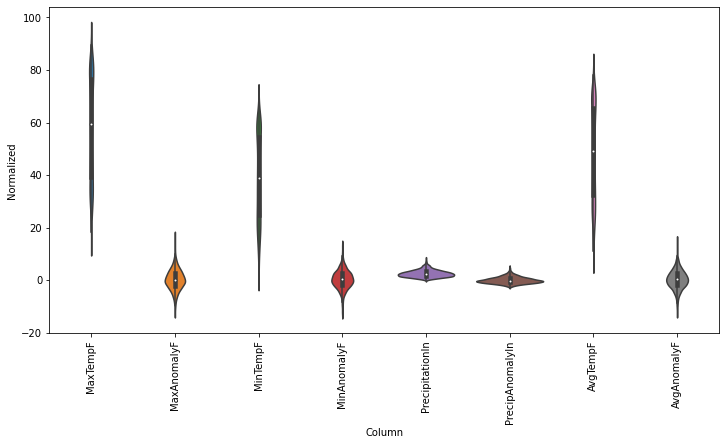

In [16]:
#visualizes normalized Wayne County data (Cook County viz is very similar)
train_mean = train_Wayne.mean()
train_std = train_Wayne.std()
df_std = (dfWayne - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfWayne.keys(), rotation=90)

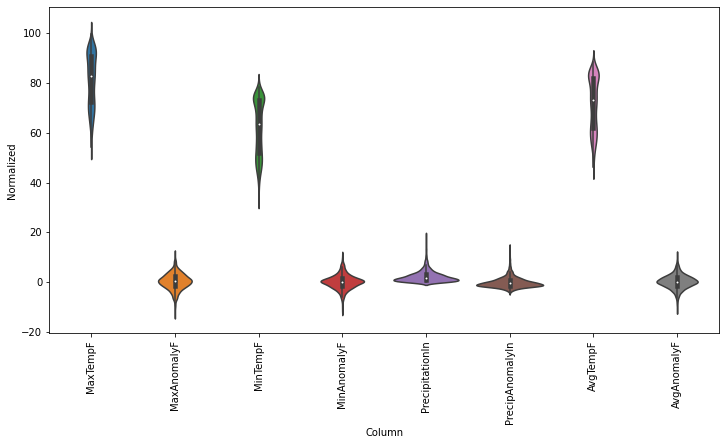

In [17]:
#visualizes normalized Nueces County data
train_mean = train_Nueces.mean()
train_std = train_Nueces.std()
df_std = (dfNueces - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfNueces.keys(), rotation=90)

In [24]:
#generates various data windows using the WindowGenerator class from Tensorflow's time series tutorial
w_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_3m = WindowGenerator(input_width=3, label_width=1, shift=3, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_1y = WindowGenerator(input_width=12, label_width=1, shift=12, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_2y = WindowGenerator(input_width=24, label_width=1, shift=24, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_5y = WindowGenerator(input_width=60, label_width=1, shift=60, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
c_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_3m = WindowGenerator(input_width=3, label_width=1, shift=3, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_1y = WindowGenerator(input_width=12, label_width=1, shift=12, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_2y = WindowGenerator(input_width=24, label_width=1, shift=24, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_5y = WindowGenerator(input_width=60, label_width=1, shift=60, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
n_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_3m = WindowGenerator(input_width=3, label_width=1, shift=3, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_1y = WindowGenerator(input_width=12, label_width=1, shift=12, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_2y = WindowGenerator(input_width=24, label_width=1, shift=24, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_5y = WindowGenerator(input_width=60, label_width=1, shift=60, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])

10/10 [==============================] - 0s 1000us/step - loss: 0.3018 - mean_absolute_error: 0.4771


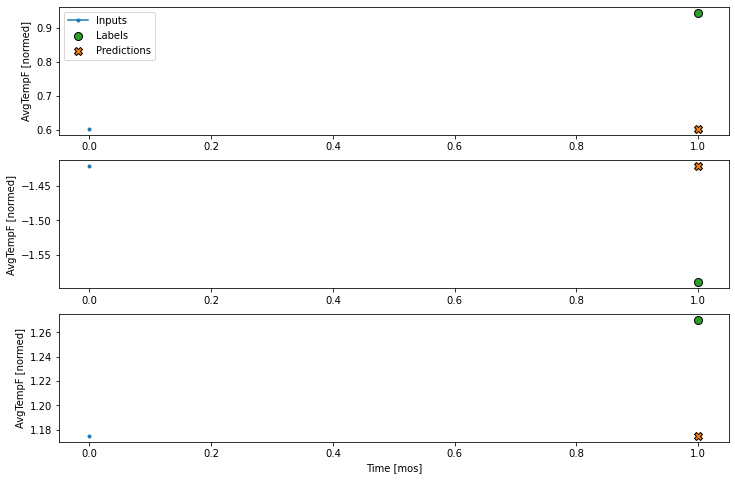

In [26]:
#baseline average temperature prediction, assumes the next month's average temp will be the same as the current
#acceptable models must outperform the baseline
baseline = Baseline(label_index=column_indices['AvgTempF'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w_1m.val)
performance['Baseline'] = baseline.evaluate(w_1m.test, verbose=0)
w_1m.plot(baseline)

Epoch 1/30
34/34 [==============================] - 0s 6ms/step - loss: 1.4840 - mean_absolute_error: 1.0614 - val_loss: 1.0968 - val_mean_absolute_error: 0.9053
Epoch 2/30
34/34 [==============================] - 0s 3ms/step - loss: 1.2014 - mean_absolute_error: 0.9582 - val_loss: 0.8921 - val_mean_absolute_error: 0.8208
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.9802 - mean_absolute_error: 0.8671 - val_loss: 0.7421 - val_mean_absolute_error: 0.7477
Epoch 4/30
34/34 [==============================] - 0s 3ms/step - loss: 0.8161 - mean_absolute_error: 0.7893 - val_loss: 0.6280 - val_mean_absolute_error: 0.6854
Epoch 5/30
34/34 [==============================] - 0s 3ms/step - loss: 0.6884 - mean_absolute_error: 0.7234 - val_loss: 0.5402 - val_mean_absolute_error: 0.6326
Epoch 6/30
34/34 [==============================] - 0s 3ms/step - loss: 0.5901 - mean_absolute_error: 0.6678 - val_loss: 0.4715 - val_mean_absolute_error: 0.5872
Epoch 7/30
34/34 [==========

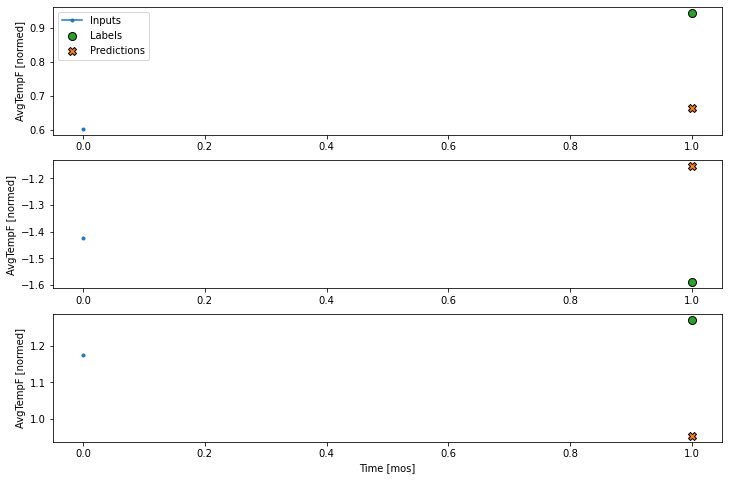

In [28]:
#linear model - single step
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(linear, w_1m)
val_performance['Linear'] = linear.evaluate(w_1m.val)
performance['Linear'] = linear.evaluate(w_1m.test, verbose=0)
w_1m.plot(linear)

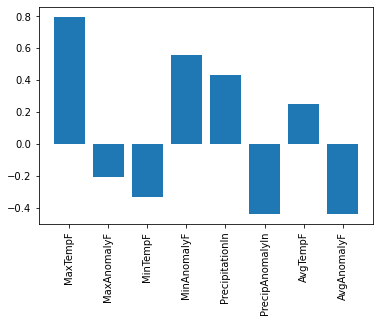

In [29]:
#shows the weights assigned to features by the linear model
plt.bar(x = range(len(train_Wayne.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_Wayne.columns)))
_ = axis.set_xticklabels(train_Wayne.columns, rotation=90)

In [30]:
#dense NN models (1,2,3 hidden layers w/ 64 nodes each) - single step
dense1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(dense1, w_1m)
val_performance['Dense-1 layer'] = dense1.evaluate(w_1m.val)
performance['Dense-1 layer'] = dense1.evaluate(w_1m.test, verbose=0)
dense2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(dense2, w_1m)
val_performance['Dense-2 layer'] = dense2.evaluate(w_1m.val)
performance['Dense-2 layer'] = dense2.evaluate(w_1m.test, verbose=0)
dense3 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(dense3, w_1m)
val_performance['Dense-3 layer'] = dense3.evaluate(w_1m.val)
performance['Dense-3 layer'] = dense3.evaluate(w_1m.test, verbose=0)

Epoch 1/30
34/34 [==============================] - 0s 6ms/step - loss: 0.5826 - mean_absolute_error: 0.6572 - val_loss: 0.3046 - val_mean_absolute_error: 0.4897
Epoch 2/30
34/34 [==============================] - 0s 4ms/step - loss: 0.2759 - mean_absolute_error: 0.4548 - val_loss: 0.2712 - val_mean_absolute_error: 0.4606
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.2577 - mean_absolute_error: 0.4366 - val_loss: 0.2632 - val_mean_absolute_error: 0.4535
Epoch 4/30
34/34 [==============================] - 0s 4ms/step - loss: 0.2479 - mean_absolute_error: 0.4292 - val_loss: 0.2583 - val_mean_absolute_error: 0.4488
Epoch 5/30
34/34 [==============================] - 0s 3ms/step - loss: 0.2416 - mean_absolute_error: 0.4232 - val_loss: 0.2530 - val_mean_absolute_error: 0.4428
Epoch 6/30
34/34 [==============================] - 0s 3ms/step - loss: 0.2362 - mean_absolute_error: 0.4193 - val_loss: 0.2471 - val_mean_absolute_error: 0.4373
Epoch 7/30
34/34 [==========

Epoch 21/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0698 - mean_absolute_error: 0.2061 - val_loss: 0.0795 - val_mean_absolute_error: 0.2249
Epoch 22/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0679 - mean_absolute_error: 0.2011 - val_loss: 0.0923 - val_mean_absolute_error: 0.2392
Epoch 23/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0682 - mean_absolute_error: 0.2011 - val_loss: 0.0745 - val_mean_absolute_error: 0.2179
Epoch 24/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0614 - mean_absolute_error: 0.1905 - val_loss: 0.0733 - val_mean_absolute_error: 0.2161
Epoch 25/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0580 - mean_absolute_error: 0.1870 - val_loss: 0.0712 - val_mean_absolute_error: 0.2141
Epoch 26/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0574 - mean_absolute_error: 0.1861 - val_loss: 0.0894 - val_mean_absolute_error: 0.2337
Epoch 27/30
34/34 [===

Epoch 1/30
34/34 [==============================] - 0s 6ms/step - loss: 1.5552 - mean_absolute_error: 1.0127 - val_loss: 0.7822 - val_mean_absolute_error: 0.7284
Epoch 2/30
34/34 [==============================] - 0s 4ms/step - loss: 0.5342 - mean_absolute_error: 0.5917 - val_loss: 0.3418 - val_mean_absolute_error: 0.4772
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.2453 - mean_absolute_error: 0.3956 - val_loss: 0.1726 - val_mean_absolute_error: 0.3303
Epoch 4/30
34/34 [==============================] - 0s 3ms/step - loss: 0.1371 - mean_absolute_error: 0.2882 - val_loss: 0.1138 - val_mean_absolute_error: 0.2616
Epoch 5/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0949 - mean_absolute_error: 0.2400 - val_loss: 0.0889 - val_mean_absolute_error: 0.2302
Epoch 6/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0750 - mean_absolute_error: 0.2142 - val_loss: 0.0769 - val_mean_absolute_error: 0.2149
Epoch 7/30
34/34 [==========

Epoch 21/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.1476 - val_loss: 0.0523 - val_mean_absolute_error: 0.1818
Epoch 22/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.1474 - val_loss: 0.0549 - val_mean_absolute_error: 0.1857
Epoch 23/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0347 - mean_absolute_error: 0.1471 - val_loss: 0.0582 - val_mean_absolute_error: 0.1913
Epoch 24/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0337 - mean_absolute_error: 0.1442 - val_loss: 0.0533 - val_mean_absolute_error: 0.1826
Epoch 25/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_absolute_error: 0.1441 - val_loss: 0.0515 - val_mean_absolute_error: 0.1797
Epoch 26/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0336 - mean_absolute_error: 0.1433 - val_loss: 0.0542 - val_mean_absolute_error: 0.1845
Epoch 27/30
34/34 [===

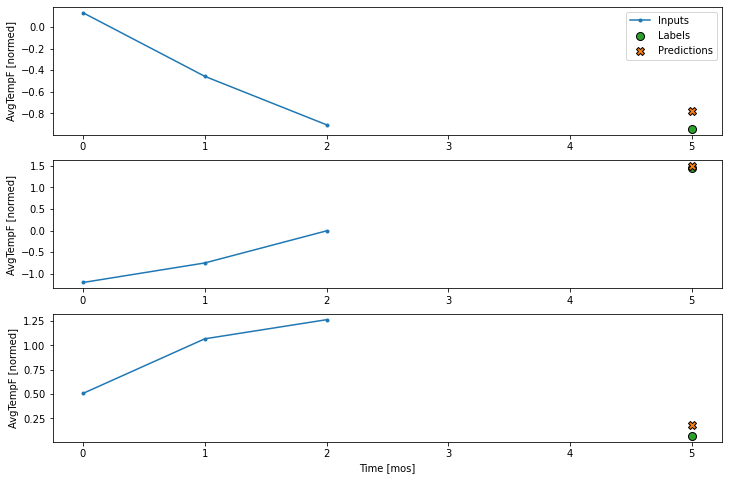

In [31]:
#dense NN models (1,2,3 hidden layers w/ 32 nodes each) - multi-step (3 mos)
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1, train_df=train_Wayne, val_df=val_Wayne, test_df=test_Wayne,
    label_columns=['AvgTempF'])

multi_step_dense1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])])
history = compile_and_fit(multi_step_dense1, w_3m)
val_performance['Multi step dense-1 layer'] = multi_step_dense1.evaluate(w_3m.val)
performance['Multi step dense-1 layer'] = multi_step_dense1.evaluate(w_3m.test, verbose=0)
multi_step_dense2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])])
history = compile_and_fit(multi_step_dense2, w_3m)
val_performance['Multi step dense-2 layer'] = multi_step_dense2.evaluate(w_3m.val)
performance['Multi step dense-2 layer'] = multi_step_dense2.evaluate(w_3m.test, verbose=0)
multi_step_dense3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])])
history = compile_and_fit(multi_step_dense3, w_3m)
val_performance['Multi step dense-3 layer'] = multi_step_dense3.evaluate(w_3m.val)
performance['Multi step dense-3 layer'] = multi_step_dense3.evaluate(w_3m.test, verbose=0)
w_3m.plot(multi_step_dense3)

Epoch 1/30
34/34 [==============================] - 0s 8ms/step - loss: 0.8284 - mean_absolute_error: 0.7798 - val_loss: 0.4269 - val_mean_absolute_error: 0.5588
Epoch 2/30
34/34 [==============================] - 0s 4ms/step - loss: 0.2868 - mean_absolute_error: 0.4392 - val_loss: 0.1294 - val_mean_absolute_error: 0.2920
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0927 - mean_absolute_error: 0.2405 - val_loss: 0.0708 - val_mean_absolute_error: 0.2136
Epoch 4/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0552 - mean_absolute_error: 0.1866 - val_loss: 0.0579 - val_mean_absolute_error: 0.1942
Epoch 5/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0474 - mean_absolute_error: 0.1716 - val_loss: 0.0576 - val_mean_absolute_error: 0.1911
Epoch 6/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0443 - mean_absolute_error: 0.1663 - val_loss: 0.0509 - val_mean_absolute_error: 0.1819
Epoch 7/30
34/34 [==========

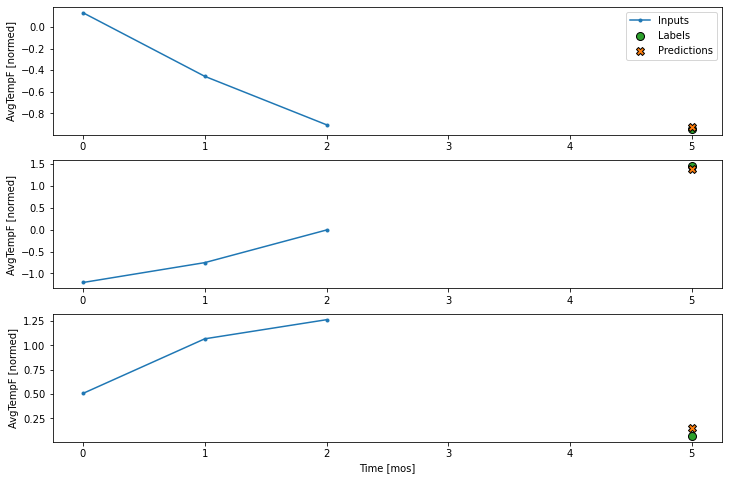

In [32]:
#convolution NN model - 1 convolution layer, 1 dense layer - multi step (3 mos)
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])
history = compile_and_fit(conv_model, w_3m)
val_performance['Conv'] = conv_model.evaluate(w_3m.val)
performance['Conv'] = conv_model.evaluate(w_3m.test, verbose=0)
w_3m.plot(conv_model)

Epoch 1/30
33/33 [==============================] - 0s 8ms/step - loss: 0.6676 - mean_absolute_error: 0.6909 - val_loss: 0.2685 - val_mean_absolute_error: 0.4379
Epoch 2/30
33/33 [==============================] - 0s 5ms/step - loss: 0.1166 - mean_absolute_error: 0.2670 - val_loss: 0.0780 - val_mean_absolute_error: 0.2178
Epoch 3/30
33/33 [==============================] - 0s 5ms/step - loss: 0.0505 - mean_absolute_error: 0.1741 - val_loss: 0.0652 - val_mean_absolute_error: 0.1990
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0418 - mean_absolute_error: 0.1586 - val_loss: 0.0612 - val_mean_absolute_error: 0.1917
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0382 - mean_absolute_error: 0.1513 - val_loss: 0.0588 - val_mean_absolute_error: 0.1880
Epoch 6/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0358 - mean_absolute_error: 0.1466 - val_loss: 0.0571 - val_mean_absolute_error: 0.1841
Epoch 7/30
33/33 [==========

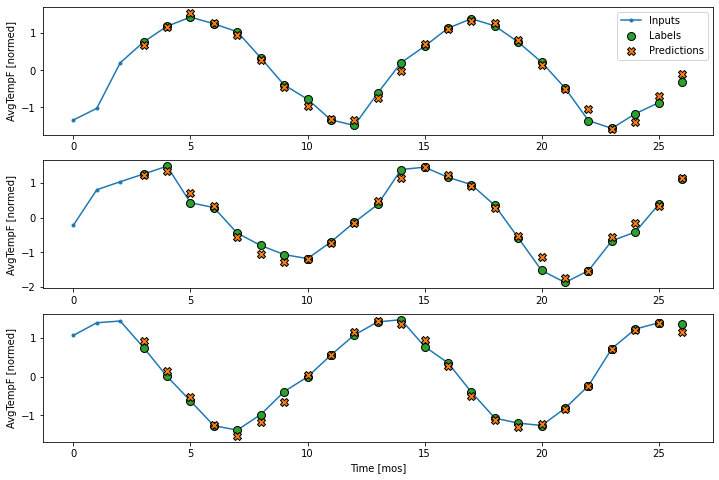

In [37]:
#convolution NN model - 1 convolution layer, 1 dense layer - single step w/ 2 yrs data
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_Wayne, val_df=val_Wayne, test_df=test_Wayne,
    label_columns=['AvgTempF'])
conv_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])
history = compile_and_fit(conv_model2, wide_conv_window)
val_performance['Conv-Wide'] = conv_model2.evaluate(wide_conv_window.val)
performance['Conv-Wide'] = conv_model2.evaluate(wide_conv_window.test, verbose=0)
wide_conv_window.plot(conv_model2)

In [44]:
#LSTM model - multi step
lstm_model1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(lstm_model1, w_2y)
val_performance['LSTM-2 yr'] = lstm_model1.evaluate(w_2y.val)
performance['LSTM-2 yr'] = lstm_model1.evaluate(w_2y.test, verbose=0)

Epoch 1/30
32/32 [==============================] - 1s 42ms/step - loss: 0.9853 - mean_absolute_error: 0.8764 - val_loss: 0.9015 - val_mean_absolute_error: 0.8327
Epoch 2/30
32/32 [==============================] - 0s 11ms/step - loss: 0.9735 - mean_absolute_error: 0.8696 - val_loss: 0.8910 - val_mean_absolute_error: 0.8281
Epoch 3/30
32/32 [==============================] - 0s 11ms/step - loss: 0.9568 - mean_absolute_error: 0.8628 - val_loss: 0.8827 - val_mean_absolute_error: 0.8265
Epoch 4/30
32/32 [==============================] - 0s 11ms/step - loss: 0.9411 - mean_absolute_error: 0.8548 - val_loss: 0.8632 - val_mean_absolute_error: 0.8182
Epoch 5/30
32/32 [==============================] - 0s 11ms/step - loss: 0.9113 - mean_absolute_error: 0.8414 - val_loss: 0.8141 - val_mean_absolute_error: 0.7921
Epoch 6/30
32/32 [==============================] - 0s 11ms/step - loss: 0.7442 - mean_absolute_error: 0.7445 - val_loss: 0.5786 - val_mean_absolute_error: 0.6270
Epoch 7/30
32/32 [====

In [45]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)])
history = compile_and_fit(lstm_model2, w_1y)
val_performance['LSTM-1 yr'] = lstm_model2.evaluate(w_1y.val)
performance['LSTM-1 yr'] = lstm_model2.evaluate(w_1y.test, verbose=0)

Epoch 1/30
33/33 [==============================] - 1s 21ms/step - loss: 0.9760 - mean_absolute_error: 0.8685 - val_loss: 0.8965 - val_mean_absolute_error: 0.8267
Epoch 2/30
33/33 [==============================] - 0s 8ms/step - loss: 0.9302 - mean_absolute_error: 0.8454 - val_loss: 0.8742 - val_mean_absolute_error: 0.8162
Epoch 3/30
33/33 [==============================] - 0s 7ms/step - loss: 0.9057 - mean_absolute_error: 0.8320 - val_loss: 0.8459 - val_mean_absolute_error: 0.8008
Epoch 4/30
33/33 [==============================] - 0s 7ms/step - loss: 0.8363 - mean_absolute_error: 0.7931 - val_loss: 0.7416 - val_mean_absolute_error: 0.7381
Epoch 5/30
33/33 [==============================] - 0s 8ms/step - loss: 0.6055 - mean_absolute_error: 0.6505 - val_loss: 0.4588 - val_mean_absolute_error: 0.5493
Epoch 6/30
33/33 [==============================] - 0s 7ms/step - loss: 0.3731 - mean_absolute_error: 0.4846 - val_loss: 0.2885 - val_mean_absolute_error: 0.4151
Epoch 7/30
33/33 [=========

Baseline    : 0.4705
Linear      : 0.4306
Dense-1 layer: 0.3097
Dense-2 layer: 0.2128
Dense-3 layer: 0.3289
Multi step dense-1 layer: 0.2020
Multi step dense-2 layer: 0.2385
Multi step dense-3 layer: 0.1932
Conv        : 0.1901
Conv-Wide   : 0.1918
LSTM-2 yr   : 0.2849
LSTM-1 yr   : 0.2510


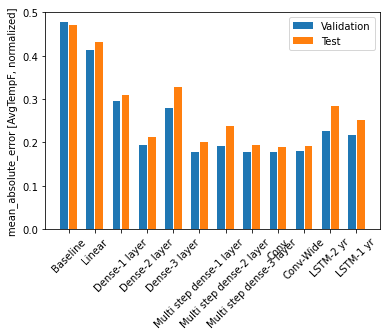

In [46]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [AvgTempF, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')